In [1]:
## charger env_ISMIP6 ou env_MIP

In [4]:
# module import
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.tri as tri
import cartopy.crs as ccrs
import pyproj
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import seaborn as sns
import datetime
import cftime
from matplotlib import gridspec
import cartopy.feature as cft
import pandas as pd
import string
import cmocean as cm
import math
import proplot as pplt
import xesmf as xe
import netCDF4 as nc
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

### data for calculation of SLE
* Methods used is similar to Goelzer et al. (2020)
* Area of ocean is from Gregory et al. (2019) (3.625e14 m2)
* rho_ice = 917 kg.m-3 (as Elmer ISMIP6 configuration)
* rho_ocean = 1028 kg.m-3 (as Elmer ISMIP6 configuration)

In [3]:
# constant
A_ocean = 3.625e14 # m2
rho_ice = 917 # kg.m-3
rho_ocean = 1028 # kg.m-3
rho_water = 1000 # kg.m-3

# conversion kg.m-2.s-1 to kg.yr-1
fac = 4*1e3 * 4*1e3 * 86400 * 365

## UKESM

### atmosphere

In [40]:
# Open data 
netCDF_file = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/MAR-UKESM1-0-LL-r10i1p1f2_asmb_2015-2100_ssp245_regrid_04000m_FROM_UKESM1-0-LL-r1i1p1f2-ssp245.nc'
ATMOU = xr.open_mfdataset(netCDF_file, decode_times=False)

netCDF_filemask = '/Users/jcaillet/Documents/Elmer/DATA/BASINS/Mask_SubRegions_IMBIE.nc'
maskS = xr.open_mfdataset(netCDF_filemask)

netCDF_filemask = '/Users/jcaillet/Documents/Elmer/DATA/BASINS/Mask_Regions_IMBIE.nc'
maskR = xr.open_mfdataset(netCDF_filemask)

netCDF_ini = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/RCM_ice_regrid_04000m.nc2'
ini = xr.open_mfdataset(netCDF_ini)

# available members
#membu = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,19])
membu = np.array([1,2,4,8])
# bassins
subbas = np.arange(1,19,1)
bas = np.arange(1,4,1)
basf = np.arange(0,4,1)

# interpolation of mask on the same grid as MAR data
ATMOU['x']=ini['x']
ATMOU['y']=ini['y']
maskS_interp = maskS.interp_like(ATMOU)
maskR_interp = maskR.interp_like(ATMOU)

#initialisation
t = np.arange(2015,2101,1)
FINAL_FILEAU = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

#boucle sur membres
for j in membu :
    data_file = f'/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/MAR-UKESM1-0-LL-r{j}i1p1f*_asmb_2015-2100_ssp245_regrid_04000m_FROM_UKESM1-0-LL-r1i1p1f2-ssp245.nc'
    RES = xr.open_mfdataset(data_file, decode_times=False)
    RES['time']=FINAL_FILEAU['time']
    # boucle sur bassins
    for i in subbas:
        FINAL_FILEAU[f'SLEA_SB{i}_{j}'] = (RES['asmb'] * fac * ini['af2'] * ini['GROUND']).where(maskS['SubBasins_extrap']==i).sum(['x','y'])
        FINAL_FILEAU[f'SLEA_SB{i}_{j}'] = -(np.cumsum(FINAL_FILEAU[f'SLEA_SB{i}_{j}']) * 1 / (A_ocean * rho_water))
    for i in bas:
        FINAL_FILEAU[f'SLEA_B{i}_{j}'] = (RES['asmb'] * fac * ini['af2'] * ini['GROUND']).where(maskR['Basins_extrap']==i).sum(['x','y'])
        FINAL_FILEAU[f'SLEA_B{i}_{j}'] = -(np.cumsum(FINAL_FILEAU[f'SLEA_B{i}_{j}']) * 1 / (A_ocean * rho_water))       
    for i in np.array([0]):
        #projection
        FINAL_FILEAU[f'SLEA_B{i}_{j}'] = (RES['asmb'] * fac * ini['af2'] * ini['GROUND']).sum(['x','y'])
        FINAL_FILEAU[f'SLEA_B{i}_{j}'] = -(np.cumsum(FINAL_FILEAU[f'SLEA_B{i}_{j}']) * 1 / (A_ocean * rho_water))
# SLE en m !

In [23]:
FINAL_FILEAU100 = xr.Dataset(data_vars=dict(memb=(["member"], membu)), coords=dict(member=membu))
t = np.arange(2015,2101,1)
MIN_MAXAU = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

for i in subbas:
    print(i)
    d = {'M1': np.array(FINAL_FILEAU[f'SLEA_SB{i}_1']), 'M2': np.array(FINAL_FILEAU[f'SLEA_SB{i}_2']), 'M3': np.array(FINAL_FILEAU[f'SLEA_SB{i}_3']), 'M4': np.array(FINAL_FILEAU[f'SLEA_SB{i}_4']), 'M5': np.array(FINAL_FILEAU[f'SLEA_SB{i}_5']), 'M6': np.array(FINAL_FILEAU[f'SLEA_SB{i}_6']), 'M7': np.array(FINAL_FILEAU[f'SLEA_SB{i}_7']), 'M8': np.array(FINAL_FILEAU[f'SLEA_SB{i}_8']), 'M9': np.array(FINAL_FILEAU[f'SLEA_SB{i}_9']), 'M10': np.array(FINAL_FILEAU[f'SLEA_SB{i}_10']), 'M11': np.array(FINAL_FILEAU[f'SLEA_SB{i}_11']), 'M12': np.array(FINAL_FILEAU[f'SLEA_SB{i}_12']), 'M13': np.array(FINAL_FILEAU[f'SLEA_SB{i}_13']), 'M16': np.array(FINAL_FILEAU[f'SLEA_SB{i}_16']), 'M17': np.array(FINAL_FILEAU[f'SLEA_SB{i}_17']), 'M18': np.array(FINAL_FILEAU[f'SLEA_SB{i}_18']), 'M19': np.array(FINAL_FILEAU[f'SLEA_SB{i}_19'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEAU100[f'SLEA_SB{i}']= FINAL_FILEAU100['memb'] - FINAL_FILEAU100['memb'] + df2100
    MIN_MAXAU[f'SLEA_SB{i}min'] = MIN_MAXAU['time_ini'] - MIN_MAXAU['time_ini'] + dfmin
    MIN_MAXAU[f'SLEA_SB{i}max'] = MIN_MAXAU['time_ini'] - MIN_MAXAU['time_ini'] + dfmax
    MIN_MAXAU[f'SLEA_SB{i}mean'] = MIN_MAXAU['time_ini'] - MIN_MAXAU['time_ini'] + dfmean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [24]:
basf = np.arange(0,4,1)
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEAU[f'SLEA_B{i}_1']), 'M2': np.array(FINAL_FILEAU[f'SLEA_B{i}_2']), 'M3': np.array(FINAL_FILEAU[f'SLEA_B{i}_3']), 'M4': np.array(FINAL_FILEAU[f'SLEA_B{i}_4']), 'M5': np.array(FINAL_FILEAU[f'SLEA_B{i}_5']), 'M6': np.array(FINAL_FILEAU[f'SLEA_B{i}_6']), 'M7': np.array(FINAL_FILEAU[f'SLEA_B{i}_7']), 'M8': np.array(FINAL_FILEAU[f'SLEA_B{i}_8']), 'M9': np.array(FINAL_FILEAU[f'SLEA_B{i}_9']), 'M10': np.array(FINAL_FILEAU[f'SLEA_B{i}_10']), 'M11': np.array(FINAL_FILEAU[f'SLEA_B{i}_11']), 'M12': np.array(FINAL_FILEAU[f'SLEA_B{i}_12']), 'M13': np.array(FINAL_FILEAU[f'SLEA_B{i}_13']), 'M16': np.array(FINAL_FILEAU[f'SLEA_B{i}_16']), 'M17': np.array(FINAL_FILEAU[f'SLEA_B{i}_17']), 'M18': np.array(FINAL_FILEAU[f'SLEA_B{i}_18']), 'M19': np.array(FINAL_FILEAU[f'SLEA_B{i}_19'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEAU100[f'SLEA_B{i}']= FINAL_FILEAU100['memb'] - FINAL_FILEAU100['memb'] + df2100
    MIN_MAXAU[f'SLEA_B{i}min'] = MIN_MAXAU['time_ini'] - MIN_MAXAU['time_ini'] + dfmin
    MIN_MAXAU[f'SLEA_B{i}max'] = MIN_MAXAU['time_ini'] - MIN_MAXAU['time_ini'] + dfmax
    MIN_MAXAU[f'SLEA_B{i}mean'] = MIN_MAXAU['time_ini'] - MIN_MAXAU['time_ini'] + dfmean

0
1
2
3


In [25]:
FINAL_FILEAU100.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/SLE2100_ATMO_UKESM_V2.nc')
MIN_MAXAU.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/SLE_minmax_ATMO_UKESM_V2.nc')

### ocean and both contribution

In [41]:
# available members
membou = np.array([1,2,4,8])
                  
# bassins
subbas = np.arange(1,19,1)
bas = np.arange(1,4,1)                

#data
netCDF_fileINI = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/ismip6_states_ismip6_w1-histae_002.nc'
RESINI = xr.open_mfdataset(netCDF_fileINI)

netCDF_filemask = '/Users/jcaillet/Documents/Elmer/Papier_ete/Mask_Regions_IMBIE_ElmerGrid.nc'
mask = xr.open_mfdataset(netCDF_filemask)

netCDF_filemasks = '/Users/jcaillet/Documents/Elmer/Papier_ete/Mask_SubRegions_IMBIE_ElmerGrid.nc'
maskSS = xr.open_mfdataset(netCDF_filemasks)

#initialisation
RESINI['time']=np.arange(2006,2016,1)
data_file = f'/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/ismip6_states_ismip6_w1-ukesmm1*.nc'
RES = xr.open_mfdataset(data_file)
t = np.arange(2015,2101,1)
FINAL_FILEU = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

#boucle sur membres
for j in membou:
    data_file = f'/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/ismip6_states_ismip6_w1-ukesmm{j}*.nc'
    RES = xr.open_mfdataset(data_file)
    RES['time'] = np.arange(2015,2101,1)
    # boucle sur bassins
    for i in subbas:
        #ref
        RESINI[f'Vaf_SB{i}'] = (RESINI['lithkaf'] * RESINI['true_cell_area']).where(maskSS['subbasins']==i).sum('nmesh2D_face')
        RESINI[f'SLE_SB{i}'] = RESINI[f'Vaf_SB{i}'] * 1 / A_ocean * rho_ice / rho_water
        #projection
        FINAL_FILEU[f'Vaf_SB{i}_{j}'] = (RES['lithkaf'] * RES['true_cell_area']).where(maskSS['subbasins']==i).sum('nmesh2D_face')
        FINAL_FILEU[f'SLEO_SB{i}_{j}'] = -((FINAL_FILEU[f'Vaf_SB{i}_{j}'] * 1 / A_ocean * rho_ice / rho_water) - RESINI[f'SLE_SB{i}'][9]) - FINAL_FILEAU[f'SLEA_SB{i}_1']
        FINAL_FILEU[f'SLEtot_SB{i}_{j}'] = FINAL_FILEU[f'SLEO_SB{i}_{j}'] + FINAL_FILEAU[f'SLEA_SB{i}_{j}']
    for i in bas:
        ##ref
        RESINI[f'Vaf_B{i}'] = (RESINI['lithkaf'] * RESINI['true_cell_area']).where(mask['basinsIM']==i).sum('nmesh2D_face')
        RESINI[f'SLE_B{i}'] = RESINI[f'Vaf_B{i}'] * 1 / A_ocean * rho_ice / rho_water
        ##projection
        ### volume above flotation
        FINAL_FILEU[f'Vaf_B{i}_{j}'] = (RES['lithkaf'] * RES['true_cell_area']).where(mask['basinsIM']==i).sum('nmesh2D_face')
        ### SLE ocean (total - atmospheric member1)
        FINAL_FILEU[f'SLEO_B{i}_{j}'] = -((FINAL_FILEU[f'Vaf_B{i}_{j}'] * 1 / A_ocean * rho_ice / rho_water) - RESINI[f'SLE_B{i}'][9]) - FINAL_FILEAU[f'SLEA_B{i}_1']
        ### SLE total (SLE ocean + SLE atmo for the same member)
        FINAL_FILEU[f'SLEtot_B{i}_{j}'] = FINAL_FILEU[f'SLEO_B{i}_{j}'] + FINAL_FILEAU[f'SLEA_B{i}_{j}']
    for i in np.array([0]):
        #ref
        RESINI[f'Vaf_B{i}'] = (RESINI['lithkaf'] * RESINI['true_cell_area']).sum('nmesh2D_face')
        RESINI[f'SLE_B{i}'] = RESINI[f'Vaf_B{i}'] * 1 / A_ocean * rho_ice / rho_water
        #projection
        FINAL_FILEU[f'Vaf_B{i}_{j}'] = (RES['lithkaf'] * RES['true_cell_area']).sum('nmesh2D_face')
        FINAL_FILEU[f'SLEO_B{i}_{j}'] = -((FINAL_FILEU[f'Vaf_B{i}_{j}'] * 1 / A_ocean * rho_ice / rho_water) - RESINI[f'SLE_B{i}'][9]) - FINAL_FILEAU[f'SLEA_B{i}_1']
        FINAL_FILEU[f'SLEtot_B{i}_{j}'] = FINAL_FILEU[f'SLEO_B{i}_{j}'] + FINAL_FILEAU[f'SLEA_B{i}_{j}']

In [180]:
FINAL_FILETU100 = xr.Dataset(data_vars=dict(memb=(["member"], membou)), coords=dict(member=membou))
t = np.arange(2015,2101,1)
MIN_MAXTU = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

for i in subbas:
    print(i)
    d = {'M1': np.array(FINAL_FILEU[f'SLEtot_SB{i}_1']), 'M2': np.array(FINAL_FILEU[f'SLEtot_SB{i}_2']), 'M4': np.array(FINAL_FILEU[f'SLEtot_SB{i}_4']), 'M8': np.array(FINAL_FILEU[f'SLEtot_SB{i}_8'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILETU100[f'SLEtot_SB{i}']= FINAL_FILETU100['memb'] - FINAL_FILETU100['memb'] + df2100
    MIN_MAXTU[f'SLEtot_SB{i}min'] = MIN_MAXTU['time_ini'] - MIN_MAXTU['time_ini'] + dfmin
    MIN_MAXTU[f'SLEtot_SB{i}max'] = MIN_MAXTU['time_ini'] - MIN_MAXTU['time_ini'] + dfmax
    MIN_MAXTU[f'SLEtot_SB{i}mean'] = MIN_MAXTU['time_ini'] - MIN_MAXTU['time_ini'] + dfmean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [181]:
basf = np.arange(0,4,1)
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEU[f'SLEtot_B{i}_1']), 'M2': np.array(FINAL_FILEU[f'SLEtot_B{i}_2']), 'M4': np.array(FINAL_FILEU[f'SLEtot_B{i}_4']), 'M8': np.array(FINAL_FILEU[f'SLEtot_B{i}_8'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILETU100[f'SLEtot_B{i}']= FINAL_FILETU100['memb'] - FINAL_FILETU100['memb'] + df2100
    MIN_MAXTU[f'SLEtot_B{i}min'] = MIN_MAXTU['time_ini'] - MIN_MAXTU['time_ini'] + dfmin
    MIN_MAXTU[f'SLEtot_B{i}max'] = MIN_MAXTU['time_ini'] - MIN_MAXTU['time_ini'] + dfmax
    MIN_MAXTU[f'SLEtot_B{i}mean'] = MIN_MAXTU['time_ini'] - MIN_MAXTU['time_ini'] + dfmean

0
1
2
3


In [72]:
t = np.arange(2015,2101,1)
MIN_MAXTU = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

d = {'M1': np.array(FINAL_FILEU[f'SLEtot_B0_1']), 'M2': np.array(FINAL_FILEU[f'SLEtot_B0_2']), 'M4': np.array(FINAL_FILEU[f'SLEtot_B0_4']), 'M8': np.array(FINAL_FILEU[f'SLEtot_B0_8'])}
df = pd.DataFrame(data=d)
dfstd = np.array(df.std(axis = 1))
dfmean = np.array(df.mean(axis = 1))
MIN_MAXTU[f'SLEtot_B0std'] = MIN_MAXTU['time_ini'] - MIN_MAXTU['time_ini'] + dfstd
MIN_MAXTU[f'SLEtot_B0mean'] = MIN_MAXTU['time_ini'] - MIN_MAXTU['time_ini'] + dfmean

In [182]:
FINAL_FILETU100.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/SLE2100_TOT_UKESM_V3.nc')
MIN_MAXTU.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/SLE_minmax_TOT_UKESM_V3.nc')

In [183]:
FINAL_FILEOU100 = xr.Dataset(data_vars=dict(memb=(["member"], membou)), coords=dict(member=membou))
t = np.arange(2015,2101,1)
MIN_MAXOU = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

for i in subbas:
    print(i)
    d = {'M1': np.array(FINAL_FILEU[f'SLEO_SB{i}_1']), 'M2': np.array(FINAL_FILEU[f'SLEO_SB{i}_2']), 'M4': np.array(FINAL_FILEU[f'SLEO_SB{i}_4']), 'M8': np.array(FINAL_FILEU[f'SLEO_SB{i}_8'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEOU100[f'SLEO_SB{i}']= FINAL_FILEOU100['memb'] - FINAL_FILEOU100['memb'] + df2100
    MIN_MAXOU[f'SLEO_SB{i}min'] = MIN_MAXOU['time_ini'] - MIN_MAXOU['time_ini'] + dfmin
    MIN_MAXOU[f'SLEO_SB{i}max'] = MIN_MAXOU['time_ini'] - MIN_MAXOU['time_ini'] + dfmax
    MIN_MAXOU[f'SLEO_SB{i}mean'] = MIN_MAXOU['time_ini'] - MIN_MAXOU['time_ini'] + dfmean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [184]:

for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEU[f'SLEO_B{i}_1']), 'M2': np.array(FINAL_FILEU[f'SLEO_B{i}_2']), 'M4': np.array(FINAL_FILEU[f'SLEO_B{i}_4']), 'M8': np.array(FINAL_FILEU[f'SLEO_B{i}_8'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEOU100[f'SLEO_B{i}']= FINAL_FILEOU100['memb'] - FINAL_FILEOU100['memb'] + df2100
    MIN_MAXOU[f'SLEO_B{i}min'] = MIN_MAXOU['time_ini'] - MIN_MAXOU['time_ini'] + dfmin
    MIN_MAXOU[f'SLEO_B{i}max'] = MIN_MAXOU['time_ini'] - MIN_MAXOU['time_ini'] + dfmax
    MIN_MAXOU[f'SLEO_B{i}mean'] = MIN_MAXOU['time_ini'] - MIN_MAXOU['time_ini'] + dfmean

0
1
2
3


In [185]:
FINAL_FILEOU100.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/SLE2100_OC_UKESM_V3.nc')
MIN_MAXOU.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/SLE_minmax_OC_UKESM_V3.nc')

## IPSL

### atmospheric

In [75]:
# Open data 
netCDF_file = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/MAR-IPSL-CM6A-LR-r1i1p1f1_asmb_2015-2100_ssp245_regrid_04000m_FROM_IPSL-CM6A-LR-r1i1p1f1-ssp585.nc'
ATMOI = xr.open_mfdataset(netCDF_file, decode_times=False)

netCDF_filemask = '/Users/jcaillet/Documents/Elmer/DATA/BASINS/Mask_SubRegions_IMBIE.nc'
maskS = xr.open_mfdataset(netCDF_filemask)

netCDF_filemask = '/Users/jcaillet/Documents/Elmer/DATA/BASINS/Mask_Regions_IMBIE.nc'
maskR = xr.open_mfdataset(netCDF_filemask)

netCDF_ini = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/RCM_ice_regrid_04000m.nc2'
ini = xr.open_mfdataset(netCDF_ini)

# available members
membi = np.array([1,2,3,4,5,6,10,11,14,22,25])

# bassins
subbas = np.arange(1,19,1)
bas = np.arange(1,4,1)
basf = np.arange(0,4,1)

# interpolation of mask on the same grid as MAR data
ATMOI['x']=ini['x']
ATMOI['y']=ini['y']
maskS_interp = maskS.interp_like(ATMOI)
maskR_interp = maskR.interp_like(ATMOI)

#initialisation
t = np.arange(2015,2101,1)
FINAL_FILEAI = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

#boucle sur membres
for j in membi :
    data_file = f'/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/MAR-IPSL-CM6A-LR-r{j}i1p1f*_asmb_2015-2100_ssp245_regrid_04000m_FROM_IPSL-CM6A-LR-r1i1p1f1-ssp585.nc'
    RES = xr.open_mfdataset(data_file, decode_times=False)
    RES['time']=FINAL_FILEAI['time']
    # boucle sur bassins
    for i in subbas:
        FINAL_FILEAI[f'SLEA_SB{i}_{j}'] = (RES['asmb'] * fac * ini['af2'] * ini['GROUND']).where(maskS['SubBasins_extrap']==i).sum(['x','y'])
        FINAL_FILEAI[f'SLEA_SB{i}_{j}'] = -(np.cumsum(FINAL_FILEAI[f'SLEA_SB{i}_{j}']) * 1 / (A_ocean * rho_water))
    for i in bas:
        FINAL_FILEAI[f'SLEA_B{i}_{j}'] = (RES['asmb'] * fac * ini['af2'] * ini['GROUND']).where(maskR['Basins_extrap']==i).sum(['x','y'])
        FINAL_FILEAI[f'SLEA_B{i}_{j}'] = -(np.cumsum(FINAL_FILEAI[f'SLEA_B{i}_{j}']) * 1 / (A_ocean * rho_water))       
    for i in np.array([0]):
        #projection
        FINAL_FILEAI[f'SLEA_B{i}_{j}'] = (RES['asmb'] * fac * ini['af2'] * ini['GROUND']).sum(['x','y'])
        FINAL_FILEAI[f'SLEA_B{i}_{j}'] = -(np.cumsum(FINAL_FILEAI[f'SLEA_B{i}_{j}']) * 1 / (A_ocean * rho_water))
# SLE en m !

In [27]:
FINAL_FILEAI100 = xr.Dataset(data_vars=dict(memb=(["member"], membi)), coords=dict(member=membi))
t = np.arange(2015,2101,1)
MIN_MAXAI = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

for i in subbas:
    print(i)
    d = {'M1': np.array(FINAL_FILEAI[f'SLEA_SB{i}_1']), 'M2': np.array(FINAL_FILEAI[f'SLEA_SB{i}_2']), 'M3': np.array(FINAL_FILEAI[f'SLEA_SB{i}_3']), 'M4': np.array(FINAL_FILEAI[f'SLEA_SB{i}_4']), 'M5': np.array(FINAL_FILEAI[f'SLEA_SB{i}_5']), 'M6': np.array(FINAL_FILEAI[f'SLEA_SB{i}_6']), 'M10': np.array(FINAL_FILEAI[f'SLEA_SB{i}_10']), 'M11': np.array(FINAL_FILEAI[f'SLEA_SB{i}_11']), 'M14': np.array(FINAL_FILEAI[f'SLEA_SB{i}_14']), 'M22': np.array(FINAL_FILEAI[f'SLEA_SB{i}_22']), 'M25': np.array(FINAL_FILEAI[f'SLEA_SB{i}_25'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEAI100[f'SLEA_SB{i}']= FINAL_FILEAI100['memb'] - FINAL_FILEAI100['memb'] + df2100
    MIN_MAXAI[f'SLEA_SB{i}min'] = MIN_MAXAI['time_ini'] - MIN_MAXAI['time_ini'] + dfmin
    MIN_MAXAI[f'SLEA_SB{i}max'] = MIN_MAXAI['time_ini'] - MIN_MAXAI['time_ini'] + dfmax
    MIN_MAXAI[f'SLEA_SB{i}mean'] = MIN_MAXAI['time_ini'] - MIN_MAXAI['time_ini'] + dfmean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [28]:
basf = np.arange(0,4,1)
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEAI[f'SLEA_B{i}_1']), 'M2': np.array(FINAL_FILEAI[f'SLEA_B{i}_2']), 'M3': np.array(FINAL_FILEAI[f'SLEA_B{i}_3']), 'M4': np.array(FINAL_FILEAI[f'SLEA_B{i}_4']), 'M5': np.array(FINAL_FILEAI[f'SLEA_B{i}_5']), 'M6': np.array(FINAL_FILEAI[f'SLEA_B{i}_6']), 'M10': np.array(FINAL_FILEAI[f'SLEA_B{i}_10']), 'M11': np.array(FINAL_FILEAI[f'SLEA_B{i}_11']), 'M14': np.array(FINAL_FILEAI[f'SLEA_B{i}_14']), 'M22': np.array(FINAL_FILEAI[f'SLEA_B{i}_22']), 'M25': np.array(FINAL_FILEAI[f'SLEA_B{i}_25'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEAI100[f'SLEA_B{i}']= FINAL_FILEAI100['memb'] - FINAL_FILEAI100['memb'] + df2100
    MIN_MAXAI[f'SLEA_B{i}min'] = MIN_MAXAI['time_ini'] - MIN_MAXAI['time_ini'] + dfmin
    MIN_MAXAI[f'SLEA_B{i}max'] = MIN_MAXAI['time_ini'] - MIN_MAXAI['time_ini'] + dfmax
    MIN_MAXAI[f'SLEA_B{i}mean'] = MIN_MAXAI['time_ini'] - MIN_MAXAI['time_ini'] + dfmean

0
1
2
3


In [29]:
FINAL_FILEAI100.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/SLE2100_ATMO_IPSL_V2.nc')
MIN_MAXAI.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/SLE_minmax_ATMO_IPSL_V2.nc')

### oceanic and both

In [76]:
# available members
memboi = np.array([1,3,6,11,25])
                  
# bassins
subbas = np.arange(1,19,1)
bas = np.arange(1,4,1)                

#data
netCDF_fileINI = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/ismip6_states_ismip6_w1-histae_002.nc'
RESINI = xr.open_mfdataset(netCDF_fileINI)

netCDF_filemask = '/Users/jcaillet/Documents/Elmer/Papier_ete/Mask_Regions_IMBIE_ElmerGrid.nc'
mask = xr.open_mfdataset(netCDF_filemask)

netCDF_filemasks = '/Users/jcaillet/Documents/Elmer/Papier_ete/Mask_SubRegions_IMBIE_ElmerGrid.nc'
maskSS = xr.open_mfdataset(netCDF_filemasks)

#initialisation
RESINI['time']=np.arange(2006,2016,1)
data_file = f'/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/ismip6_states_ismip6_w1-ipslm1_*.nc'
RES = xr.open_mfdataset(data_file)
t = np.arange(2015,2101,1)
FINAL_FILEI = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

#boucle sur membres
for j in memboi:
    data_file = f'/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/ismip6_states_ismip6_w1-ipslm{j}_*.nc'
    RES = xr.open_mfdataset(data_file)
    RES['time'] = np.arange(2015,2101,1)
    # boucle sur bassins
    for i in subbas:
        #ref
        RESINI[f'Vaf_SB{i}'] = (RESINI['lithkaf'] * RESINI['true_cell_area']).where(maskSS['subbasins']==i).sum('nmesh2D_face')
        RESINI[f'SLE_SB{i}'] = RESINI[f'Vaf_SB{i}'] * 1 / A_ocean * rho_ice / rho_water
        #projection
        FINAL_FILEI[f'Vaf_SB{i}_{j}'] = (RES['lithkaf'] * RES['true_cell_area']).where(maskSS['subbasins']==i).sum('nmesh2D_face')       
        FINAL_FILEI[f'SLEO_SB{i}_{j}'] = -((FINAL_FILEI[f'Vaf_SB{i}_{j}'] * 1 / A_ocean * rho_ice / rho_water) - RESINI[f'SLE_SB{i}'][9]) - FINAL_FILEAI[f'SLEA_SB{i}_1']
        FINAL_FILEI[f'SLEtot_SB{i}_{j}'] = FINAL_FILEI[f'SLEO_SB{i}_{j}'] + FINAL_FILEAI[f'SLEA_SB{i}_{j}']
    for i in bas:
        ##ref
        RESINI[f'Vaf_B{i}'] = (RESINI['lithkaf'] * RESINI['true_cell_area']).where(mask['basinsIM']==i).sum('nmesh2D_face')
        RESINI[f'SLE_B{i}'] = RESINI[f'Vaf_B{i}'] * 1 / A_ocean * rho_ice / rho_water
        ##projection
        FINAL_FILEI[f'Vaf_B{i}_{j}'] = (RES['lithkaf'] * RES['true_cell_area']).where(mask['basinsIM']==i).sum('nmesh2D_face')
        FINAL_FILEI[f'SLEO_B{i}_{j}'] = -((FINAL_FILEI[f'Vaf_B{i}_{j}'] * 1 / A_ocean * rho_ice / rho_water) - RESINI[f'SLE_B{i}'][9]) - FINAL_FILEAI[f'SLEA_B{i}_1']
        FINAL_FILEI[f'SLEtot_B{i}_{j}'] = FINAL_FILEI[f'SLEO_B{i}_{j}'] + FINAL_FILEAI[f'SLEA_B{i}_{j}']
    for i in np.array([0]):
        #ref
        RESINI[f'Vaf_B{i}'] = (RESINI['lithkaf'] * RESINI['true_cell_area']).sum('nmesh2D_face')
        RESINI[f'SLE_B{i}'] = RESINI[f'Vaf_B{i}'] * 1 / A_ocean * rho_ice / rho_water
        #projection
        FINAL_FILEI[f'Vaf_B{i}_{j}'] = (RES['lithkaf'] * RES['true_cell_area']).sum('nmesh2D_face')
        FINAL_FILEI[f'SLEO_B{i}_{j}'] = -((FINAL_FILEI[f'Vaf_B{i}_{j}'] * 1 / A_ocean * rho_ice / rho_water) - RESINI[f'SLE_B{i}'][9]) - FINAL_FILEAI[f'SLEA_B{i}_1']
        FINAL_FILEI[f'SLEtot_B{i}_{j}'] = FINAL_FILEI[f'SLEO_B{i}_{j}'] + FINAL_FILEAI[f'SLEA_B{i}_{j}']

In [9]:
FINAL_FILETI100 = xr.Dataset(data_vars=dict(memb=(["member"], memboi)), coords=dict(member=memboi))
t = np.arange(2015,2101,1)
MIN_MAXTI = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

for i in subbas:
    print(i)
    d = {'M1': np.array(FINAL_FILEI[f'SLEtot_SB{i}_1']), 'M3': np.array(FINAL_FILEI[f'SLEtot_SB{i}_3']), 'M6': np.array(FINAL_FILEI[f'SLEtot_SB{i}_6']), 'M11': np.array(FINAL_FILEI[f'SLEtot_SB{i}_11']), 'M25': np.array(FINAL_FILEI[f'SLEtot_SB{i}_25'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILETI100[f'SLEtot_SB{i}']= FINAL_FILETI100['memb'] - FINAL_FILETI100['memb'] + df2100
    MIN_MAXTI[f'SLEtot_SB{i}min'] = MIN_MAXTI['time_ini'] - MIN_MAXTI['time_ini'] + dfmin
    MIN_MAXTI[f'SLEtot_SB{i}max'] = MIN_MAXTI['time_ini'] - MIN_MAXTI['time_ini'] + dfmax
    MIN_MAXTI[f'SLEtot_SB{i}mean'] = MIN_MAXTI['time_ini'] - MIN_MAXTI['time_ini'] + dfmean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [10]:
basf = np.arange(0,4,1)
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEI[f'SLEtot_B{i}_1']), 'M3': np.array(FINAL_FILEI[f'SLEtot_B{i}_3']), 'M6': np.array(FINAL_FILEI[f'SLEtot_B{i}_6']), 'M11': np.array(FINAL_FILEI[f'SLEtot_B{i}_11']), 'M25': np.array(FINAL_FILEI[f'SLEtot_B{i}_25'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILETI100[f'SLEtot_B{i}']= FINAL_FILETI100['memb'] - FINAL_FILETI100['memb'] + df2100
    MIN_MAXTI[f'SLEtot_B{i}min'] = MIN_MAXTI['time_ini'] - MIN_MAXTI['time_ini'] + dfmin
    MIN_MAXTI[f'SLEtot_B{i}max'] = MIN_MAXTI['time_ini'] - MIN_MAXTI['time_ini'] + dfmax
    MIN_MAXTI[f'SLEtot_B{i}mean'] = MIN_MAXTI['time_ini'] - MIN_MAXTI['time_ini'] + dfmean

0
1
2
3


In [77]:
t = np.arange(2015,2101,1)
MIN_MAXTI = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))
basf = np.arange(0,1,1)
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEI[f'SLEtot_B{i}_1']), 'M3': np.array(FINAL_FILEI[f'SLEtot_B{i}_3']), 'M6': np.array(FINAL_FILEI[f'SLEtot_B{i}_6']), 'M11': np.array(FINAL_FILEI[f'SLEtot_B{i}_11']), 'M25': np.array(FINAL_FILEI[f'SLEtot_B{i}_25'])}
    df = pd.DataFrame(data=d)
    dfstd = np.array(df.std(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    MIN_MAXTI[f'SLEtot_B{i}std'] = MIN_MAXTI['time_ini'] - MIN_MAXTI['time_ini'] + dfstd
    MIN_MAXTI[f'SLEtot_B{i}mean'] = MIN_MAXTI['time_ini'] - MIN_MAXTI['time_ini'] + dfmean

0


In [11]:
FINAL_FILETI100.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/SLE2100_TOT_IPSL_V3.nc')
MIN_MAXTI.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/SLE_minmax_TOT_IPSL_V3.nc')

In [12]:
FINAL_FILEOI100 = xr.Dataset(data_vars=dict(memb=(["member"], memboi)), coords=dict(member=memboi))
t = np.arange(2015,2101,1)
MIN_MAXOI = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

for i in subbas:
    print(i)
    d = {'M1': np.array(FINAL_FILEI[f'SLEO_SB{i}_1']), 'M3': np.array(FINAL_FILEI[f'SLEO_SB{i}_3']), 'M6': np.array(FINAL_FILEI[f'SLEO_SB{i}_6']), 'M11': np.array(FINAL_FILEI[f'SLEO_SB{i}_11']), 'M25': np.array(FINAL_FILEI[f'SLEO_SB{i}_25'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEOI100[f'SLEO_SB{i}']= FINAL_FILEOI100['memb'] - FINAL_FILEOI100['memb'] + df2100
    MIN_MAXOI[f'SLEO_SB{i}min'] = MIN_MAXOI['time_ini'] - MIN_MAXOI['time_ini'] + dfmin
    MIN_MAXOI[f'SLEO_SB{i}max'] = MIN_MAXOI['time_ini'] - MIN_MAXOI['time_ini'] + dfmax
    MIN_MAXOI[f'SLEO_SB{i}mean'] = MIN_MAXOI['time_ini'] - MIN_MAXOI['time_ini'] + dfmean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [13]:
basf = np.arange(0,4,1)
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEI[f'SLEO_B{i}_1']), 'M3': np.array(FINAL_FILEI[f'SLEO_B{i}_3']), 'M6': np.array(FINAL_FILEI[f'SLEO_B{i}_6']), 'M11': np.array(FINAL_FILEI[f'SLEO_B{i}_11']), 'M25': np.array(FINAL_FILEI[f'SLEO_B{i}_25'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEOI100[f'SLEO_B{i}']= FINAL_FILEOI100['memb'] - FINAL_FILEOI100['memb'] + df2100
    MIN_MAXOI[f'SLEO_B{i}min'] = MIN_MAXOI['time_ini'] - MIN_MAXOI['time_ini'] + dfmin
    MIN_MAXOI[f'SLEO_B{i}max'] = MIN_MAXOI['time_ini'] - MIN_MAXOI['time_ini'] + dfmax
    MIN_MAXOI[f'SLEO_B{i}mean'] = MIN_MAXOI['time_ini'] - MIN_MAXOI['time_ini'] + dfmean

0
1
2
3


In [14]:
FINAL_FILEOI100.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/SLE2100_OC_IPSL_V3.nc')
MIN_MAXOI.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/SLE_minmax_OC_IPSL_V3.nc')

## MPI

### atmospheric

In [80]:
# Open data 
netCDF_file = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/MAR-MPI-ESM1-2-HR-r1i1p1f1_asmb_2015-2100_ssp245_regrid_04000m_FROM_MPI-ESM1-2-HR-r1i1p1f1-ssp245.nc'
ATMOM = xr.open_mfdataset(netCDF_file, decode_times=False)

netCDF_filemask = '/Users/jcaillet/Documents/Elmer/DATA/BASINS/Mask_SubRegions_IMBIE.nc'
maskS = xr.open_mfdataset(netCDF_filemask)

netCDF_filemask = '/Users/jcaillet/Documents/Elmer/DATA/BASINS/Mask_Regions_IMBIE.nc'
maskR = xr.open_mfdataset(netCDF_filemask)

netCDF_ini = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/RCM_ice_regrid_04000m.nc2'
ini = xr.open_mfdataset(netCDF_ini)

# available members
membm = np.array([1,2])

# bassins
subbas = np.arange(1,19,1)
bas = np.arange(1,4,1)
basf = np.arange(0,4,1)

# interpolation of mask on the same grid as MAR data
ATMOM['x']=ini['x']
ATMOM['y']=ini['y']
maskS_interp = maskS.interp_like(ATMOM)
maskR_interp = maskR.interp_like(ATMOM)

#initialisation
t = np.arange(2015,2101,1)
FINAL_FILEAM = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

#boucle sur membres
for j in membm :
    data_file = f'/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/MAR-MPI-ESM1-2-HR-r{j}i1p1f*_asmb_2015-2100_ssp245_regrid_04000m_FROM_MPI-ESM1-2-HR-r1i1p1f1-ssp245.nc'
    RES = xr.open_mfdataset(data_file, decode_times=False)
    RES['time']=FINAL_FILEAM['time']
    # boucle sur bassins
    for i in subbas:
        FINAL_FILEAM[f'SLEA_SB{i}_{j}'] = (RES['asmb'] * fac * ini['af2'] * ini['GROUND']).where(maskS['SubBasins_extrap']==i).sum(['x','y'])
        FINAL_FILEAM[f'SLEA_SB{i}_{j}'] = -(np.cumsum(FINAL_FILEAM[f'SLEA_SB{i}_{j}']) * 1 / (A_ocean * rho_water))
    for i in bas:
        FINAL_FILEAM[f'SLEA_B{i}_{j}'] = (RES['asmb'] * fac * ini['af2'] * ini['GROUND']).where(maskR['Basins_extrap']==i).sum(['x','y'])
        FINAL_FILEAM[f'SLEA_B{i}_{j}'] = -(np.cumsum(FINAL_FILEAM[f'SLEA_B{i}_{j}']) * 1 / (A_ocean * rho_water))       
    for i in np.array([0]):
        #projection
        FINAL_FILEAM[f'SLEA_B{i}_{j}'] = (RES['asmb'] * fac * ini['af2'] * ini['GROUND']).sum(['x','y'])
        FINAL_FILEAM[f'SLEA_B{i}_{j}'] = -(np.cumsum(FINAL_FILEAM[f'SLEA_B{i}_{j}']) * 1 / (A_ocean * rho_water))
# SLE en m !

In [38]:
FINAL_FILEAM100 = xr.Dataset(data_vars=dict(memb=(["member"], membm)), coords=dict(member=membm))
t = np.arange(2015,2101,1)
MIN_MAXAM = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

for i in subbas:
    print(i)
    d = {'M1': np.array(FINAL_FILEAM[f'SLEA_SB{i}_1']), 'M2': np.array(FINAL_FILEAM[f'SLEA_SB{i}_2'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEAM100[f'SLEA_SB{i}']= FINAL_FILEAM100['memb'] - FINAL_FILEAM100['memb'] + df2100
    MIN_MAXAM[f'SLEA_SB{i}min'] = MIN_MAXAM['time_ini'] - MIN_MAXAM['time_ini'] + dfmin
    MIN_MAXAM[f'SLEA_SB{i}max'] = MIN_MAXAM['time_ini'] - MIN_MAXAM['time_ini'] + dfmax
    MIN_MAXAM[f'SLEA_SB{i}mean'] = MIN_MAXAM['time_ini'] - MIN_MAXAM['time_ini'] + dfmean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [39]:
basf = np.arange(0,4,1)
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEAM[f'SLEA_B{i}_1']), 'M2': np.array(FINAL_FILEAM[f'SLEA_B{i}_2'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEAM100[f'SLEA_B{i}']= FINAL_FILEAM100['memb'] - FINAL_FILEAM100['memb'] + df2100
    MIN_MAXAM[f'SLEA_B{i}min'] = MIN_MAXAM['time_ini'] - MIN_MAXAM['time_ini'] + dfmin
    MIN_MAXAM[f'SLEA_B{i}max'] = MIN_MAXAM['time_ini'] - MIN_MAXAM['time_ini'] + dfmax
    MIN_MAXAM[f'SLEA_B{i}mean'] = MIN_MAXAM['time_ini'] - MIN_MAXAM['time_ini'] + dfmean

0
1
2
3


In [40]:
FINAL_FILEAM100.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/SLE2100_ATMO_MPI_V2.nc')
MIN_MAXAM.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/SLE_minmax_ATMO_MPI_V2.nc')

### oceanic and both contribution

In [81]:
# available members
membom = np.array([1,2])
                  
# bassins
subbas = np.arange(1,19,1)
bas = np.arange(1,4,1)                

#data
netCDF_fileINI = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/ismip6_states_ismip6_w1-histae_002.nc'
RESINI = xr.open_mfdataset(netCDF_fileINI)

netCDF_filemask = '/Users/jcaillet/Documents/Elmer/Papier_ete/Mask_Regions_IMBIE_ElmerGrid.nc'
mask = xr.open_mfdataset(netCDF_filemask)

netCDF_filemasks = '/Users/jcaillet/Documents/Elmer/Papier_ete/Mask_SubRegions_IMBIE_ElmerGrid.nc'
maskSS = xr.open_mfdataset(netCDF_filemasks)

#initialisation
RESINI['time']=np.arange(2006,2016,1)
data_file = f'/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/ismip6_states_ismip6_w1-mpim1*.nc'
RES = xr.open_mfdataset(data_file)
t = np.arange(2015,2101,1)
FINAL_FILEM = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

#boucle sur membres
for j in membom:
    data_file = f'/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/ismip6_states_ismip6_w1-mpim{j}_*.nc'
    RES = xr.open_mfdataset(data_file)
    RES['time'] = np.arange(2015,2101,1)
    # boucle sur bassins
    for i in subbas:
        #ref
        RESINI[f'Vaf_SB{i}'] = (RESINI['lithkaf'] * RESINI['true_cell_area']).where(maskSS['subbasins']==i).sum('nmesh2D_face')
        RESINI[f'SLE_SB{i}'] = RESINI[f'Vaf_SB{i}'] * 1 / A_ocean * rho_ice / rho_water
        #projection
        FINAL_FILEM[f'Vaf_SB{i}_{j}'] = (RES['lithkaf'] * RES['true_cell_area']).where(maskSS['subbasins']==i).sum('nmesh2D_face')
        FINAL_FILEM[f'SLEO_SB{i}_{j}'] = -((FINAL_FILEM[f'Vaf_SB{i}_{j}'] * 1 / A_ocean * rho_ice / rho_water) - RESINI[f'SLE_SB{i}'][9]) - FINAL_FILEAM[f'SLEA_SB{i}_1']
        FINAL_FILEM[f'SLEtot_SB{i}_{j}'] = FINAL_FILEM[f'SLEO_SB{i}_{j}'] + FINAL_FILEAM[f'SLEA_SB{i}_{j}']
    for i in bas:
        ##ref
        RESINI[f'Vaf_B{i}'] = (RESINI['lithkaf'] * RESINI['true_cell_area']).where(mask['basinsIM']==i).sum('nmesh2D_face')
        RESINI[f'SLE_B{i}'] = RESINI[f'Vaf_B{i}'] * 1 / A_ocean * rho_ice / rho_water
        ##projection
        FINAL_FILEM[f'Vaf_B{i}_{j}'] = (RES['lithkaf'] * RES['true_cell_area']).where(mask['basinsIM']==i).sum('nmesh2D_face')
        FINAL_FILEM[f'SLEO_B{i}_{j}'] = -((FINAL_FILEM[f'Vaf_B{i}_{j}'] * 1 / A_ocean * rho_ice / rho_water) - RESINI[f'SLE_B{i}'][9]) - FINAL_FILEAM[f'SLEA_B{i}_1']
        FINAL_FILEM[f'SLEtot_B{i}_{j}'] = FINAL_FILEM[f'SLEO_B{i}_{j}'] + FINAL_FILEAM[f'SLEA_B{i}_{j}']
        
    for i in np.array([0]):
        #ref
        RESINI[f'Vaf_B{i}'] = (RESINI['lithkaf'] * RESINI['true_cell_area']).sum('nmesh2D_face')
        RESINI[f'SLE_B{i}'] = RESINI[f'Vaf_B{i}'] * 1 / A_ocean * rho_ice / rho_water
        #projection
        FINAL_FILEM[f'Vaf_B{i}_{j}'] = (RES['lithkaf'] * RES['true_cell_area']).sum('nmesh2D_face')
        FINAL_FILEM[f'SLEO_B{i}_{j}'] = -((FINAL_FILEM[f'Vaf_B{i}_{j}'] * 1 / A_ocean * rho_ice / rho_water) - RESINI[f'SLE_B{i}'][9]) - FINAL_FILEAM[f'SLEA_B{i}_1']
        FINAL_FILEM[f'SLEtot_B{i}_{j}'] = FINAL_FILEM[f'SLEO_B{i}_{j}'] + FINAL_FILEAM[f'SLEA_B{i}_{j}']

In [17]:
FINAL_FILETM100 = xr.Dataset(data_vars=dict(memb=(["member"], membom)), coords=dict(member=membom))
t = np.arange(2015,2101,1)
MIN_MAXTM = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

for i in subbas:
    print(i)
    d = {'M1': np.array(FINAL_FILEM[f'SLEtot_SB{i}_1']), 'M2': np.array(FINAL_FILEM[f'SLEtot_SB{i}_2'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILETM100[f'SLEtot_SB{i}']= FINAL_FILETM100['memb'] - FINAL_FILETM100['memb'] + df2100
    MIN_MAXTM[f'SLEtot_SB{i}min'] = MIN_MAXTM['time_ini'] - MIN_MAXTM['time_ini'] + dfmin
    MIN_MAXTM[f'SLEtot_SB{i}max'] = MIN_MAXTM['time_ini'] - MIN_MAXTM['time_ini'] + dfmax
    MIN_MAXTM[f'SLEtot_SB{i}mean'] = MIN_MAXTM['time_ini'] - MIN_MAXTM['time_ini'] + dfmean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [18]:
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEM[f'SLEtot_B{i}_1']), 'M2': np.array(FINAL_FILEM[f'SLEtot_B{i}_2'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILETM100[f'SLEtot_B{i}']= FINAL_FILETM100['memb'] - FINAL_FILETM100['memb'] + df2100
    MIN_MAXTM[f'SLEtot_B{i}min'] = MIN_MAXTM['time_ini'] - MIN_MAXTM['time_ini'] + dfmin
    MIN_MAXTM[f'SLEtot_B{i}max'] = MIN_MAXTM['time_ini'] - MIN_MAXTM['time_ini'] + dfmax
    MIN_MAXTM[f'SLEtot_B{i}mean'] = MIN_MAXTM['time_ini'] - MIN_MAXTM['time_ini'] + dfmean

0
1
2
3


In [83]:
t = np.arange(2015,2101,1)
MIN_MAXTM = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))
basf = np.arange(0,1,1) 
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEM[f'SLEtot_B{i}_1']), 'M2': np.array(FINAL_FILEM[f'SLEtot_B{i}_2'])}
    df = pd.DataFrame(data=d)
    dfstd = np.array(df.std(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    MIN_MAXTM[f'SLEtot_B{i}std'] = MIN_MAXTM['time_ini'] - MIN_MAXTM['time_ini'] + dfstd
    MIN_MAXTM[f'SLEtot_B{i}mean'] = MIN_MAXTM['time_ini'] - MIN_MAXTM['time_ini'] + dfmean

0


In [19]:
FINAL_FILETM100.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/SLE2100_TOT_MPI_V3.nc')
MIN_MAXTM.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/SLE_minmax_TOT_MPI_V3.nc')

In [20]:
FINAL_FILEOM100 = xr.Dataset(data_vars=dict(memb=(["member"], membom)), coords=dict(member=membom))
t = np.arange(2015,2101,1)
MIN_MAXOM = xr.Dataset(data_vars=dict(time_ini=(["time"], t)), coords=dict(time=t))

for i in subbas:
    print(i)
    d = {'M1': np.array(FINAL_FILEM[f'SLEO_SB{i}_1']), 'M2': np.array(FINAL_FILEM[f'SLEO_SB{i}_2'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEOM100[f'SLEO_SB{i}']= FINAL_FILEOM100['memb'] - FINAL_FILEOM100['memb'] + df2100
    MIN_MAXOM[f'SLEO_SB{i}min'] = MIN_MAXOM['time_ini'] - MIN_MAXOM['time_ini'] + dfmin
    MIN_MAXOM[f'SLEO_SB{i}max'] = MIN_MAXOM['time_ini'] - MIN_MAXOM['time_ini'] + dfmax
    MIN_MAXOM[f'SLEO_SB{i}mean'] = MIN_MAXOM['time_ini'] - MIN_MAXOM['time_ini'] + dfmean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [21]:
for i in basf:
    print(i)
    d = {'M1': np.array(FINAL_FILEM[f'SLEO_B{i}_1']), 'M2': np.array(FINAL_FILEM[f'SLEO_B{i}_2'])}
    df = pd.DataFrame(data=d)
    dfmin = np.array(df.min(axis = 1))
    dfmax = np.array(df.max(axis = 1))
    dfmean = np.array(df.mean(axis = 1))
    df2100 = np.array(df.iloc[85])
    FINAL_FILEOM100[f'SLEO_B{i}']= FINAL_FILEOM100['memb'] - FINAL_FILEOM100['memb'] + df2100
    MIN_MAXOM[f'SLEO_B{i}min'] = MIN_MAXOM['time_ini'] - MIN_MAXOM['time_ini'] + dfmin
    MIN_MAXOM[f'SLEO_B{i}max'] = MIN_MAXOM['time_ini'] - MIN_MAXOM['time_ini'] + dfmax
    MIN_MAXOM[f'SLEO_B{i}mean'] = MIN_MAXOM['time_ini'] - MIN_MAXOM['time_ini'] + dfmean

0
1
2
3


In [22]:
FINAL_FILEOM100.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/SLE2100_OC_MPI_V3.nc')
MIN_MAXOM.to_netcdf('/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/SLE_minmax_OC_MPI_V3.nc')

## Figure

In [5]:
# open netcdf file
SLE2100_OC_UK = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/SLE2100_OC_UKESM_V3.nc'
SLE2100_ATMO_UK = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/SLE2100_ATMO_UKESM_V2.nc'
SLE2100_TOT_UK = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/UKESM/SLE2100_TOT_UKESM_V3.nc'
UKESM_SLE2100_OC = xr.open_mfdataset(SLE2100_OC_UK)
UKESM_SLE2100_ATMO = xr.open_mfdataset(SLE2100_ATMO_UK)
UKESM_SLE2100_TOT = xr.open_mfdataset(SLE2100_TOT_UK)

SLE2100_OC_IP = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/SLE2100_OC_IPSL_V3.nc'
SLE2100_ATMO_IP = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/SLE2100_ATMO_IPSL_V2.nc'
SLE2100_TOT_IP = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/IPSL/SLE2100_TOT_IPSL_V3.nc'
IPSL_SLE2100_OC = xr.open_mfdataset(SLE2100_OC_IP)
IPSL_SLE2100_ATMO = xr.open_mfdataset(SLE2100_ATMO_IP)
IPSL_SLE2100_TOT = xr.open_mfdataset(SLE2100_TOT_IP)

SLE2100_OC_MP = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/SLE2100_OC_MPI_V3.nc'
SLE2100_ATMO_MP = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/SLE2100_ATMO_MPI_V2.nc'
SLE2100_TOT_MP = '/Users/jcaillet/Documents/Elmer/CMIP6/DATA/MPI/SLE2100_TOT_MPI_V3.nc'
MPI_SLE2100_OC = xr.open_mfdataset(SLE2100_OC_MP)
MPI_SLE2100_ATMO = xr.open_mfdataset(SLE2100_ATMO_MP)
MPI_SLE2100_TOT = xr.open_mfdataset(SLE2100_TOT_MP)
                 
                 
#data_tot_uk = [UKESM_SLE2100_TOT['SLEtot_SB1'], UKESM_SLE2100_TOT['SLEtot_SB2'], UKESM_SLE2100_TOT['SLEtot_SB3'], UKESM_SLE2100_TOT['SLEtot_SB4'], UKESM_SLE2100_TOT['SLEtot_SB5'], UKESM_SLE2100_TOT['SLEtot_SB6'], UKESM_SLE2100_TOT['SLEtot_SB7'], UKESM_SLE2100_TOT['SLEtot_SB8'], UKESM_SLE2100_TOT['SLEtot_SB9'], UKESM_SLE2100_TOT['SLEtot_SB10'], UKESM_SLE2100_TOT['SLEtot_SB11'], UKESM_SLE2100_TOT['SLEtot_SB12'], UKESM_SLE2100_TOT['SLEtot_SB13'], UKESM_SLE2100_TOT['SLEtot_SB14'], UKESM_SLE2100_TOT['SLEtot_SB15'], UKESM_SLE2100_TOT['SLEtot_SB16'], UKESM_SLE2100_TOT['SLEtot_SB17'], UKESM_SLE2100_TOT['SLEtot_SB18']]
#data_oc_uk = [UKESM_SLE2100_OC['SLEO_SB1'], UKESM_SLE2100_OC['SLEO_SB2'], UKESM_SLE2100_OC['SLEO_SB3'], UKESM_SLE2100_OC['SLEO_SB4'], UKESM_SLE2100_OC['SLEO_SB5'], UKESM_SLE2100_OC['SLEO_SB6'], UKESM_SLE2100_OC['SLEO_SB7'], UKESM_SLE2100_OC['SLEO_SB8'], UKESM_SLE2100_OC['SLEO_SB9'], UKESM_SLE2100_OC['SLEO_SB10'], UKESM_SLE2100_OC['SLEO_SB11'], UKESM_SLE2100_OC['SLEO_SB12'], UKESM_SLE2100_OC['SLEO_SB13'], UKESM_SLE2100_OC['SLEO_SB14'], UKESM_SLE2100_OC['SLEO_SB15'], UKESM_SLE2100_OC['SLEO_SB16'], UKESM_SLE2100_OC['SLEO_SB17'], UKESM_SLE2100_OC['SLEO_SB18']]
#data_atmo_uk = [UKESM_SLE2100_ATMO['SLEA_SB1'], UKESM_SLE2100_ATMO['SLEA_SB2'], UKESM_SLE2100_ATMO['SLEA_SB3'], UKESM_SLE2100_ATMO['SLEA_SB4'], UKESM_SLE2100_ATMO['SLEA_SB5'], UKESM_SLE2100_ATMO['SLEA_SB6'], UKESM_SLE2100_ATMO['SLEA_SB7'], UKESM_SLE2100_ATMO['SLEA_SB8'], UKESM_SLE2100_ATMO['SLEA_SB9'], UKESM_SLE2100_ATMO['SLEA_SB10'], UKESM_SLE2100_ATMO['SLEA_SB11'], UKESM_SLE2100_ATMO['SLEA_SB12'], UKESM_SLE2100_ATMO['SLEA_SB13'], UKESM_SLE2100_ATMO['SLEA_SB14'], UKESM_SLE2100_ATMO['SLEA_SB15'], UKESM_SLE2100_ATMO['SLEA_SB16'], UKESM_SLE2100_ATMO['SLEA_SB17'], UKESM_SLE2100_ATMO['SLEA_SB18']]

#data_tot_ip = [IPSL_SLE2100_TOT['SLEtot_SB1'], IPSL_SLE2100_TOT['SLEtot_SB2'], IPSL_SLE2100_TOT['SLEtot_SB3'], IPSL_SLE2100_TOT['SLEtot_SB4'], IPSL_SLE2100_TOT['SLEtot_SB5'], IPSL_SLE2100_TOT['SLEtot_SB6'], IPSL_SLE2100_TOT['SLEtot_SB7'], IPSL_SLE2100_TOT['SLEtot_SB8'], IPSL_SLE2100_TOT['SLEtot_SB9'], IPSL_SLE2100_TOT['SLEtot_SB10'], IPSL_SLE2100_TOT['SLEtot_SB11'], IPSL_SLE2100_TOT['SLEtot_SB12'], IPSL_SLE2100_TOT['SLEtot_SB13'], IPSL_SLE2100_TOT['SLEtot_SB14'], IPSL_SLE2100_TOT['SLEtot_SB15'], IPSL_SLE2100_TOT['SLEtot_SB16'], IPSL_SLE2100_TOT['SLEtot_SB17'], IPSL_SLE2100_TOT['SLEtot_SB18']]
#data_oc_ip = [IPSL_SLE2100_OC['SLEO_SB1'], IPSL_SLE2100_OC['SLEO_SB2'], IPSL_SLE2100_OC['SLEO_SB3'], IPSL_SLE2100_OC['SLEO_SB4'], IPSL_SLE2100_OC['SLEO_SB5'], IPSL_SLE2100_OC['SLEO_SB6'], IPSL_SLE2100_OC['SLEO_SB7'], IPSL_SLE2100_OC['SLEO_SB8'], IPSL_SLE2100_OC['SLEO_SB9'], IPSL_SLE2100_OC['SLEO_SB10'], IPSL_SLE2100_OC['SLEO_SB11'], IPSL_SLE2100_OC['SLEO_SB12'], IPSL_SLE2100_OC['SLEO_SB13'], IPSL_SLE2100_OC['SLEO_SB14'], IPSL_SLE2100_OC['SLEO_SB15'], IPSL_SLE2100_OC['SLEO_SB16'], IPSL_SLE2100_OC['SLEO_SB17'], IPSL_SLE2100_OC['SLEO_SB18']]
#data_atmo_ip = [IPSL_SLE2100_ATMO['SLEA_SB1'], IPSL_SLE2100_ATMO['SLEA_SB2'], IPSL_SLE2100_ATMO['SLEA_SB3'], IPSL_SLE2100_ATMO['SLEA_SB4'], IPSL_SLE2100_ATMO['SLEA_SB5'], IPSL_SLE2100_ATMO['SLEA_SB6'], IPSL_SLE2100_ATMO['SLEA_SB7'], IPSL_SLE2100_ATMO['SLEA_SB8'], IPSL_SLE2100_ATMO['SLEA_SB9'], IPSL_SLE2100_ATMO['SLEA_SB10'], IPSL_SLE2100_ATMO['SLEA_SB11'], IPSL_SLE2100_ATMO['SLEA_SB12'], IPSL_SLE2100_ATMO['SLEA_SB13'], IPSL_SLE2100_ATMO['SLEA_SB14'], IPSL_SLE2100_ATMO['SLEA_SB15'], IPSL_SLE2100_ATMO['SLEA_SB16'], IPSL_SLE2100_ATMO['SLEA_SB17'], IPSL_SLE2100_ATMO['SLEA_SB18']]

#data_tot_mp = [MPI_SLE2100_TOT['SLEtot_SB1'], MPI_SLE2100_TOT['SLEtot_SB2'], MPI_SLE2100_TOT['SLEtot_SB3'], MPI_SLE2100_TOT['SLEtot_SB4'], MPI_SLE2100_TOT['SLEtot_SB5'], MPI_SLE2100_TOT['SLEtot_SB6'], MPI_SLE2100_TOT['SLEtot_SB7'], MPI_SLE2100_TOT['SLEtot_SB8'], MPI_SLE2100_TOT['SLEtot_SB9'], MPI_SLE2100_TOT['SLEtot_SB10'], MPI_SLE2100_TOT['SLEtot_SB11'], MPI_SLE2100_TOT['SLEtot_SB12'], MPI_SLE2100_TOT['SLEtot_SB13'], MPI_SLE2100_TOT['SLEtot_SB14'], MPI_SLE2100_TOT['SLEtot_SB15'], MPI_SLE2100_TOT['SLEtot_SB16'], MPI_SLE2100_TOT['SLEtot_SB17'], MPI_SLE2100_TOT['SLEtot_SB18']]
#data_oc_mp = [MPI_SLE2100_OC['SLEO_SB1'], MPI_SLE2100_OC['SLEO_SB2'], MPI_SLE2100_OC['SLEO_SB3'], MPI_SLE2100_OC['SLEO_SB4'], MPI_SLE2100_OC['SLEO_SB5'], MPI_SLE2100_OC['SLEO_SB6'], MPI_SLE2100_OC['SLEO_SB7'], MPI_SLE2100_OC['SLEO_SB8'], MPI_SLE2100_OC['SLEO_SB9'], MPI_SLE2100_OC['SLEO_SB10'], MPI_SLE2100_OC['SLEO_SB11'], MPI_SLE2100_OC['SLEO_SB12'], MPI_SLE2100_OC['SLEO_SB13'], MPI_SLE2100_OC['SLEO_SB14'], MPI_SLE2100_OC['SLEO_SB15'], MPI_SLE2100_OC['SLEO_SB16'], MPI_SLE2100_OC['SLEO_SB17'], MPI_SLE2100_OC['SLEO_SB18']]
#data_atmo_mp = [MPI_SLE2100_ATMO['SLEA_SB1'], MPI_SLE2100_ATMO['SLEA_SB2'], MPI_SLE2100_ATMO['SLEA_SB3'], MPI_SLE2100_ATMO['SLEA_SB4'], MPI_SLE2100_ATMO['SLEA_SB5'], MPI_SLE2100_ATMO['SLEA_SB6'], MPI_SLE2100_ATMO['SLEA_SB7'], MPI_SLE2100_ATMO['SLEA_SB8'], MPI_SLE2100_ATMO['SLEA_SB9'], MPI_SLE2100_ATMO['SLEA_SB10'], MPI_SLE2100_ATMO['SLEA_SB11'], MPI_SLE2100_ATMO['SLEA_SB12'], MPI_SLE2100_ATMO['SLEA_SB13'], MPI_SLE2100_ATMO['SLEA_SB14'], MPI_SLE2100_ATMO['SLEA_SB15'], MPI_SLE2100_ATMO['SLEA_SB16'], MPI_SLE2100_ATMO['SLEA_SB17'], MPI_SLE2100_ATMO['SLEA_SB18']]

data_tot_uk = [UKESM_SLE2100_TOT['SLEtot_SB1']*1e2, UKESM_SLE2100_TOT['SLEtot_SB2']*1e2, UKESM_SLE2100_TOT['SLEtot_SB3']*1e2, UKESM_SLE2100_TOT['SLEtot_SB4']*1e2, UKESM_SLE2100_TOT['SLEtot_SB5']*1e2, UKESM_SLE2100_TOT['SLEtot_SB6']*1e2, UKESM_SLE2100_TOT['SLEtot_SB7']*1e2, UKESM_SLE2100_TOT['SLEtot_SB8']*1e2, UKESM_SLE2100_TOT['SLEtot_SB9']*1e2, UKESM_SLE2100_TOT['SLEtot_SB10']*1e2, UKESM_SLE2100_TOT['SLEtot_SB11']*1e2, UKESM_SLE2100_TOT['SLEtot_SB12']*1e2, UKESM_SLE2100_TOT['SLEtot_SB13']*1e2, UKESM_SLE2100_TOT['SLEtot_SB14']*1e2, UKESM_SLE2100_TOT['SLEtot_SB15']*1e2, UKESM_SLE2100_TOT['SLEtot_SB16']*1e2, UKESM_SLE2100_TOT['SLEtot_SB17']*1e2, UKESM_SLE2100_TOT['SLEtot_SB18']*1e2]
data_oc_uk = [UKESM_SLE2100_OC['SLEO_SB1']*1e2, UKESM_SLE2100_OC['SLEO_SB2']*1e2, UKESM_SLE2100_OC['SLEO_SB3']*1e2, UKESM_SLE2100_OC['SLEO_SB4']*1e2, UKESM_SLE2100_OC['SLEO_SB5']*1e2, UKESM_SLE2100_OC['SLEO_SB6']*1e2, UKESM_SLE2100_OC['SLEO_SB7']*1e2, UKESM_SLE2100_OC['SLEO_SB8']*1e2, UKESM_SLE2100_OC['SLEO_SB9']*1e2, UKESM_SLE2100_OC['SLEO_SB10']*1e2, UKESM_SLE2100_OC['SLEO_SB11']*1e2, UKESM_SLE2100_OC['SLEO_SB12']*1e2, UKESM_SLE2100_OC['SLEO_SB13']*1e2, UKESM_SLE2100_OC['SLEO_SB14']*1e2, UKESM_SLE2100_OC['SLEO_SB15']*1e2, UKESM_SLE2100_OC['SLEO_SB16']*1e2, UKESM_SLE2100_OC['SLEO_SB17']*1e2, UKESM_SLE2100_OC['SLEO_SB18']*1e2]
data_atmo_uk = [UKESM_SLE2100_ATMO['SLEA_SB1']*1e2, UKESM_SLE2100_ATMO['SLEA_SB2']*1e2, UKESM_SLE2100_ATMO['SLEA_SB3']*1e2, UKESM_SLE2100_ATMO['SLEA_SB4']*1e2, UKESM_SLE2100_ATMO['SLEA_SB5']*1e2, UKESM_SLE2100_ATMO['SLEA_SB6']*1e2, UKESM_SLE2100_ATMO['SLEA_SB7']*1e2, UKESM_SLE2100_ATMO['SLEA_SB8']*1e2, UKESM_SLE2100_ATMO['SLEA_SB9']*1e2, UKESM_SLE2100_ATMO['SLEA_SB10']*1e2, UKESM_SLE2100_ATMO['SLEA_SB11']*1e2, UKESM_SLE2100_ATMO['SLEA_SB12']*1e2, UKESM_SLE2100_ATMO['SLEA_SB13']*1e2, UKESM_SLE2100_ATMO['SLEA_SB14']*1e2, UKESM_SLE2100_ATMO['SLEA_SB15']*1e2, UKESM_SLE2100_ATMO['SLEA_SB16']*1e2, UKESM_SLE2100_ATMO['SLEA_SB17']*1e2, UKESM_SLE2100_ATMO['SLEA_SB18']*1e2]

data_tot_ip = [IPSL_SLE2100_TOT['SLEtot_SB1']*1e2, IPSL_SLE2100_TOT['SLEtot_SB2']*1e2, IPSL_SLE2100_TOT['SLEtot_SB3']*1e2, IPSL_SLE2100_TOT['SLEtot_SB4']*1e2, IPSL_SLE2100_TOT['SLEtot_SB5']*1e2, IPSL_SLE2100_TOT['SLEtot_SB6']*1e2, IPSL_SLE2100_TOT['SLEtot_SB7']*1e2, IPSL_SLE2100_TOT['SLEtot_SB8']*1e2, IPSL_SLE2100_TOT['SLEtot_SB9']*1e2, IPSL_SLE2100_TOT['SLEtot_SB10']*1e2, IPSL_SLE2100_TOT['SLEtot_SB11']*1e2, IPSL_SLE2100_TOT['SLEtot_SB12']*1e2, IPSL_SLE2100_TOT['SLEtot_SB13']*1e2, IPSL_SLE2100_TOT['SLEtot_SB14']*1e2, IPSL_SLE2100_TOT['SLEtot_SB15']*1e2, IPSL_SLE2100_TOT['SLEtot_SB16']*1e2, IPSL_SLE2100_TOT['SLEtot_SB17']*1e2, IPSL_SLE2100_TOT['SLEtot_SB18']*1e2]
data_oc_ip = [IPSL_SLE2100_OC['SLEO_SB1']*1e2, IPSL_SLE2100_OC['SLEO_SB2']*1e2, IPSL_SLE2100_OC['SLEO_SB3']*1e2, IPSL_SLE2100_OC['SLEO_SB4']*1e2, IPSL_SLE2100_OC['SLEO_SB5']*1e2, IPSL_SLE2100_OC['SLEO_SB6']*1e2, IPSL_SLE2100_OC['SLEO_SB7']*1e2, IPSL_SLE2100_OC['SLEO_SB8']*1e2, IPSL_SLE2100_OC['SLEO_SB9']*1e2, IPSL_SLE2100_OC['SLEO_SB10']*1e2, IPSL_SLE2100_OC['SLEO_SB11']*1e2, IPSL_SLE2100_OC['SLEO_SB12']*1e2, IPSL_SLE2100_OC['SLEO_SB13']*1e2, IPSL_SLE2100_OC['SLEO_SB14']*1e2, IPSL_SLE2100_OC['SLEO_SB15']*1e2, IPSL_SLE2100_OC['SLEO_SB16']*1e2, IPSL_SLE2100_OC['SLEO_SB17']*1e2, IPSL_SLE2100_OC['SLEO_SB18']*1e2]
data_atmo_ip = [IPSL_SLE2100_ATMO['SLEA_SB1']*1e2, IPSL_SLE2100_ATMO['SLEA_SB2']*1e2, IPSL_SLE2100_ATMO['SLEA_SB3']*1e2, IPSL_SLE2100_ATMO['SLEA_SB4']*1e2, IPSL_SLE2100_ATMO['SLEA_SB5']*1e2, IPSL_SLE2100_ATMO['SLEA_SB6']*1e2, IPSL_SLE2100_ATMO['SLEA_SB7']*1e2, IPSL_SLE2100_ATMO['SLEA_SB8']*1e2, IPSL_SLE2100_ATMO['SLEA_SB9']*1e2, IPSL_SLE2100_ATMO['SLEA_SB10']*1e2, IPSL_SLE2100_ATMO['SLEA_SB11']*1e2, IPSL_SLE2100_ATMO['SLEA_SB12']*1e2, IPSL_SLE2100_ATMO['SLEA_SB13']*1e2, IPSL_SLE2100_ATMO['SLEA_SB14']*1e2, IPSL_SLE2100_ATMO['SLEA_SB15']*1e2, IPSL_SLE2100_ATMO['SLEA_SB16']*1e2, IPSL_SLE2100_ATMO['SLEA_SB17']*1e2, IPSL_SLE2100_ATMO['SLEA_SB18']*1e2]

data_tot_mp = [MPI_SLE2100_TOT['SLEtot_SB1']*1e2, MPI_SLE2100_TOT['SLEtot_SB2']*1e2, MPI_SLE2100_TOT['SLEtot_SB3']*1e2, MPI_SLE2100_TOT['SLEtot_SB4']*1e2, MPI_SLE2100_TOT['SLEtot_SB5']*1e2, MPI_SLE2100_TOT['SLEtot_SB6']*1e2, MPI_SLE2100_TOT['SLEtot_SB7']*1e2, MPI_SLE2100_TOT['SLEtot_SB8']*1e2, MPI_SLE2100_TOT['SLEtot_SB9']*1e2, MPI_SLE2100_TOT['SLEtot_SB10']*1e2, MPI_SLE2100_TOT['SLEtot_SB11']*1e2, MPI_SLE2100_TOT['SLEtot_SB12']*1e2, MPI_SLE2100_TOT['SLEtot_SB13']*1e2, MPI_SLE2100_TOT['SLEtot_SB14']*1e2, MPI_SLE2100_TOT['SLEtot_SB15']*1e2, MPI_SLE2100_TOT['SLEtot_SB16']*1e2, MPI_SLE2100_TOT['SLEtot_SB17']*1e2, MPI_SLE2100_TOT['SLEtot_SB18']*1e2]
data_oc_mp = [MPI_SLE2100_OC['SLEO_SB1']*1e2, MPI_SLE2100_OC['SLEO_SB2']*1e2, MPI_SLE2100_OC['SLEO_SB3']*1e2, MPI_SLE2100_OC['SLEO_SB4']*1e2, MPI_SLE2100_OC['SLEO_SB5']*1e2, MPI_SLE2100_OC['SLEO_SB6']*1e2, MPI_SLE2100_OC['SLEO_SB7']*1e2, MPI_SLE2100_OC['SLEO_SB8']*1e2, MPI_SLE2100_OC['SLEO_SB9']*1e2, MPI_SLE2100_OC['SLEO_SB10']*1e2, MPI_SLE2100_OC['SLEO_SB11']*1e2, MPI_SLE2100_OC['SLEO_SB12']*1e2, MPI_SLE2100_OC['SLEO_SB13']*1e2, MPI_SLE2100_OC['SLEO_SB14']*1e2, MPI_SLE2100_OC['SLEO_SB15']*1e2, MPI_SLE2100_OC['SLEO_SB16']*1e2, MPI_SLE2100_OC['SLEO_SB17']*1e2, MPI_SLE2100_OC['SLEO_SB18']*1e2]
data_atmo_mp = [MPI_SLE2100_ATMO['SLEA_SB1']*1e2, MPI_SLE2100_ATMO['SLEA_SB2']*1e2, MPI_SLE2100_ATMO['SLEA_SB3']*1e2, MPI_SLE2100_ATMO['SLEA_SB4']*1e2, MPI_SLE2100_ATMO['SLEA_SB5']*1e2, MPI_SLE2100_ATMO['SLEA_SB6']*1e2, MPI_SLE2100_ATMO['SLEA_SB7']*1e2, MPI_SLE2100_ATMO['SLEA_SB8']*1e2, MPI_SLE2100_ATMO['SLEA_SB9']*1e2, MPI_SLE2100_ATMO['SLEA_SB10']*1e2, MPI_SLE2100_ATMO['SLEA_SB11']*1e2, MPI_SLE2100_ATMO['SLEA_SB12']*1e2, MPI_SLE2100_ATMO['SLEA_SB13']*1e2, MPI_SLE2100_ATMO['SLEA_SB14']*1e2, MPI_SLE2100_ATMO['SLEA_SB15']*1e2, MPI_SLE2100_ATMO['SLEA_SB16']*1e2, MPI_SLE2100_ATMO['SLEA_SB17']*1e2, MPI_SLE2100_ATMO['SLEA_SB18']*1e2]


#data_tot_uk = [UKESM_SLE2100_TOT['SLEtot_B1'], UKESM_SLE2100_TOT['SLEtot_B2'], UKESM_SLE2100_TOT['SLEtot_B3']]
#data_oc_uk = [UKESM_SLE2100_OC['SLEO_B1'], UKESM_SLE2100_OC['SLEO_B2'], UKESM_SLE2100_OC['SLEO_B3']]
#data_atmo_uk = [UKESM_SLE2100_ATMO['SLEA_B1'], UKESM_SLE2100_ATMO['SLEA_B2'], UKESM_SLE2100_ATMO['SLEA_B3']]

#data_tot_ip = [IPSL_SLE2100_TOT['SLEtot_B1'], IPSL_SLE2100_TOT['SLEtot_B2'], IPSL_SLE2100_TOT['SLEtot_B3']]
#data_oc_ip = [IPSL_SLE2100_OC['SLEO_B1'], IPSL_SLE2100_OC['SLEO_B2'], IPSL_SLE2100_OC['SLEO_B3']]
#data_atmo_ip = [IPSL_SLE2100_ATMO['SLEA_B1'], IPSL_SLE2100_ATMO['SLEA_B2'], IPSL_SLE2100_ATMO['SLEA_B3']]

#data_tot_mp = [MPI_SLE2100_TOT['SLEtot_B1'], MPI_SLE2100_TOT['SLEtot_B2'], MPI_SLE2100_TOT['SLEtot_B3']]
#data_oc_mp = [MPI_SLE2100_OC['SLEO_B1'], MPI_SLE2100_OC['SLEO_B2'], MPI_SLE2100_OC['SLEO_B3']]
#data_atmo_mp = [MPI_SLE2100_ATMO['SLEA_B1'], MPI_SLE2100_ATMO['SLEA_B2'], MPI_SLE2100_ATMO['SLEA_B3']]


#calculation of mean
list_mean_tot_uk =[]
list_mean_tot_ip =[]
list_mean_tot_mp =[]
list_mean_oc_uk =[]
list_mean_oc_ip =[]
list_mean_oc_mp =[]
list_mean_atmo_uk =[]
list_mean_atmo_ip =[]
list_mean_atmo_mp =[]

for i in data_tot_uk :
    list_mean_tot_uk.append(float(i.mean()))
for i in data_tot_ip :
    list_mean_tot_ip.append(float(i.mean()))
for i in data_tot_mp :
    list_mean_tot_mp.append(float(i.mean()))
for i in data_oc_uk :
    list_mean_oc_uk.append(float(i.mean()))
for i in data_oc_ip :
    list_mean_oc_ip.append(float(i.mean()))
for i in data_oc_mp :
    list_mean_oc_mp.append(float(i.mean()))
for i in data_atmo_uk :
    list_mean_atmo_uk.append(float(i.mean()))
for i in data_atmo_ip :
    list_mean_atmo_ip.append(float(i.mean()))
for i in data_atmo_mp :
    list_mean_atmo_mp.append(float(i.mean()))

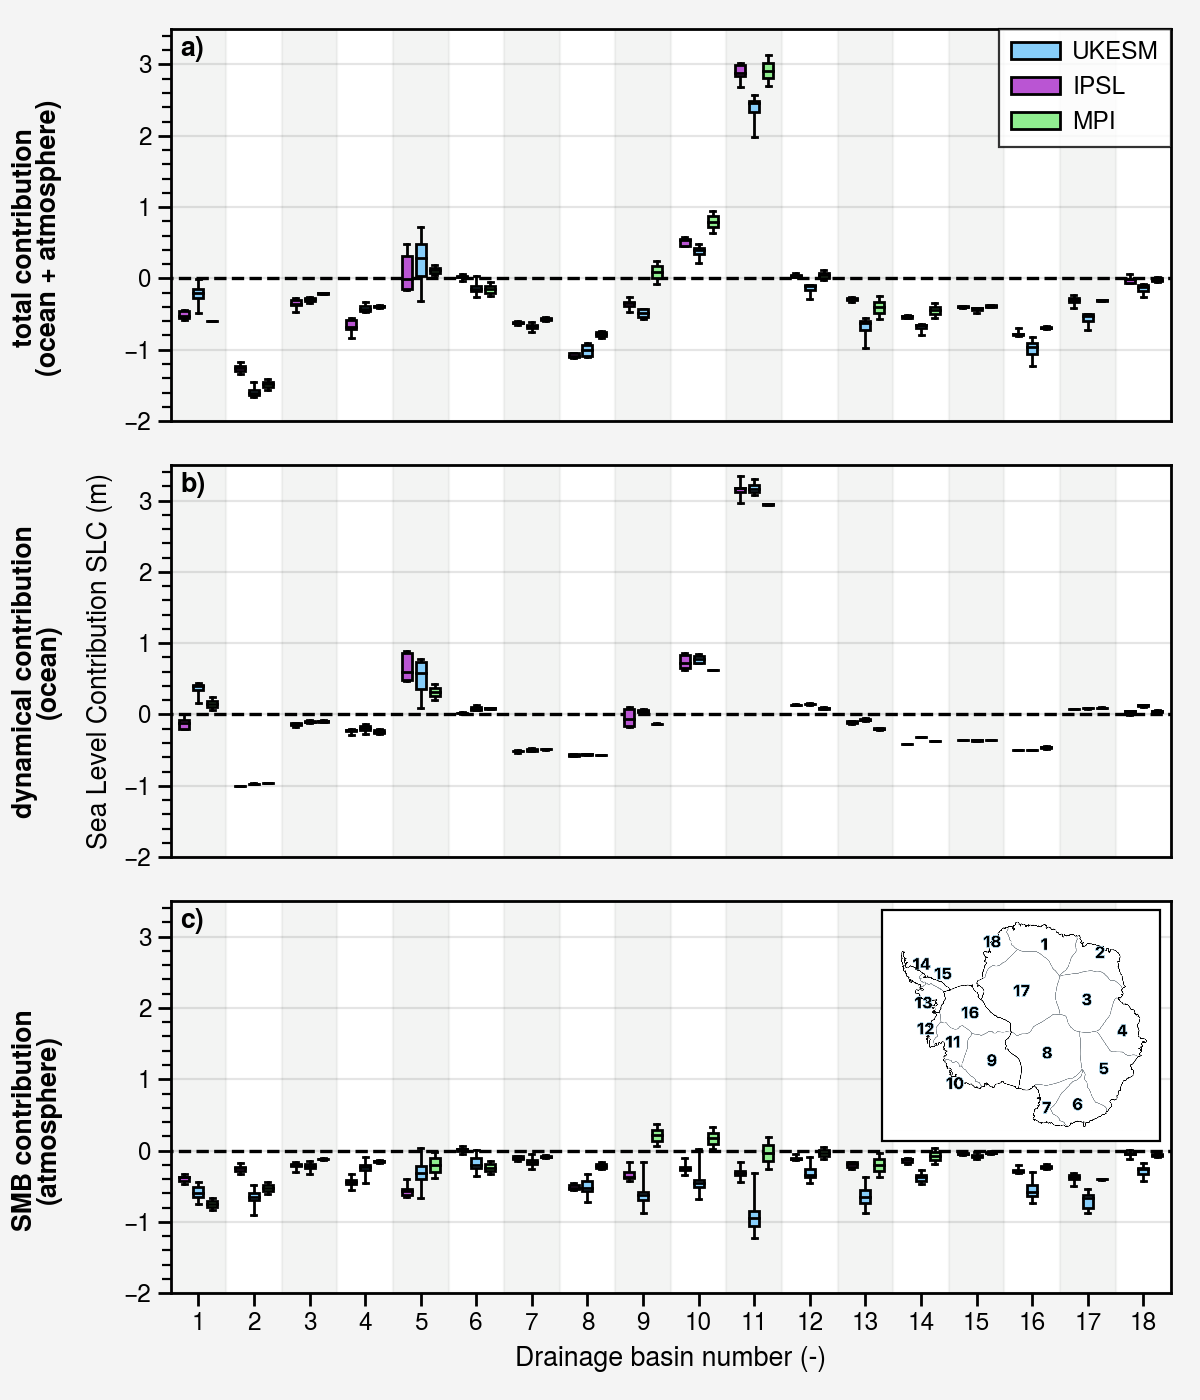

In [6]:
sns.set_context('paper')


colorsu = ['lightskyblue','lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue','lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue']
colorsi = ['mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid']
colorsm = ['lightgreen','lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen']

major_ticks = np.arange(1, 19, 1)


f = plt.figure(figsize = (6, 7))
ax={}
nb_rows = 3
nb_cols = 1

plt.figtext(0.01, 0.83, 'total contribution', verticalalignment='center', rotation=90, fontweight="bold")
plt.figtext(0.03, 0.83, '(ocean + atmosphere)', verticalalignment='center', rotation=90, fontweight="bold")
plt.figtext(0.01, 0.52, 'dynamical contribution', verticalalignment='center', rotation=90, fontweight="bold")
plt.figtext(0.03, 0.52, '(ocean)', verticalalignment='center', rotation=90, fontweight="bold")
plt.figtext(0.01, 0.2, 'SMB contribution', verticalalignment='center', rotation=90, fontweight="bold")
plt.figtext(0.03, 0.2, '(atmosphere)', verticalalignment='center', rotation=90, fontweight="bold")



ax[0] = f.add_subplot(3,1,1)
## boxplot for total contribution
boxplotu = ax[0].boxplot(x=[group.values for group in data_tot_uk], patch_artist=True, medianprops={'color': 'black'}, widths=0.18, positions=np.arange(1,19,1), whis=(0, 100))
boxploti = ax[0].boxplot(x=[group.values for group in data_tot_ip], patch_artist=True, medianprops={'color': 'black'}, widths=0.18, positions=np.arange(0.75,18.75,1), whis=(0, 100)) 
boxplotm = ax[0].boxplot(x=[group.values for group in data_tot_mp], patch_artist=True, medianprops={'color': 'black'}, widths=0.18, positions=np.arange(1.25,19.25,1), whis=(0, 100))
for box, color in zip(boxplotu['boxes'], colorsu):
    box.set_facecolor(color)
for box, color in zip(boxploti['boxes'], colorsi):
    box.set_facecolor(color)
for box, color in zip(boxplotm['boxes'], colorsm):
    box.set_facecolor(color)
ax[0].set_xticks(major_ticks)
ax[0].hlines(0, 0, 19, linewidth = 1.2, linestyle='--',colors= 'black')
ax[0].set_xlim(0.5,18.5)
ax[0].set_ylim(-2,3.5)
ax[0].axes.xaxis.set_ticklabels([])
ax[0].legend([boxplotu["boxes"][0], boxploti["boxes"][0],boxplotm["boxes"][0]], ['UKESM', 'IPSL', 'MPI'], loc='upper right')
for k in np.arange(0,19,2):
    ax[0].axvspan(k+0.5, k+1.5, alpha=0.1, color='grey')
ax[0].get_xaxis().set_visible(False)


ax[1] = f.add_subplot(3,1,2)
## boxplot for ocean contribution
boxplotou = ax[1].boxplot(x=[group.values for group in data_oc_uk], patch_artist=True, medianprops={'color': 'black'}, widths=0.18, positions=np.arange(1,19,1), whis=(0, 100))
boxplotoi = ax[1].boxplot(x=[group.values for group in data_oc_ip], patch_artist=True, medianprops={'color': 'black'}, widths=0.18, positions=np.arange(0.75,18.75,1), whis=(0, 100)) 
boxplotom = ax[1].boxplot(x=[group.values for group in data_oc_mp], patch_artist=True, medianprops={'color': 'black'}, widths=0.18, positions=np.arange(1.25,19.25,1), whis=(0, 100))
for box, color in zip(boxplotou['boxes'], colorsu):
    box.set_facecolor(color)
for box, color in zip(boxplotoi['boxes'], colorsi):
    box.set_facecolor(color)
for box, color in zip(boxplotom['boxes'], colorsm):
    box.set_facecolor(color)
ax[1].set_xticks(major_ticks)
ax[1].hlines(0, 0, 19, linewidth = 1.2, linestyle='--',colors= 'black')
ax[1].set_xlim(0.5,18.5)
ax[1].set_ylim(-2,3.5)
ax[1].set_ylabel('Sea Level Contribution SLC (m)')
ax[1].axes.xaxis.set_ticklabels([])
for k in np.arange(0,19,2):
    ax[1].axvspan(k+0.5, k+1.5, alpha=0.1, color='grey')
ax[1].get_xaxis().set_visible(False)

ax[2] = f.add_subplot(3,1,3)
## boxplot for atmosphere contribution
boxplotau = ax[2].boxplot(x=[group.values for group in data_atmo_uk], patch_artist=True, medianprops={'color': 'black'}, widths=0.18, positions=np.arange(1,19,1), whis=(0, 100))
boxplotai = ax[2].boxplot(x=[group.values for group in data_atmo_ip], patch_artist=True, medianprops={'color': 'black'}, widths=0.18, positions=np.arange(0.75,18.75,1), whis=(0, 100)) 
boxplotam = ax[2].boxplot(x=[group.values for group in data_atmo_mp], patch_artist=True, medianprops={'color': 'black'}, widths=0.18, positions=np.arange(1.25,19.25,1), whis=(0, 100))
for box, color in zip(boxplotau['boxes'], colorsu):
    box.set_facecolor(color)
for box, color in zip(boxplotai['boxes'], colorsi):
    box.set_facecolor(color)
for box, color in zip(boxplotam['boxes'], colorsm):
    box.set_facecolor(color)
ax[2].set_xticks(major_ticks)
ax[2].hlines(0, 0, 19, linewidth = 1.2, linestyle='--',colors= 'black')
ax[2].set_xlim(0.5,18.5)
ax[2].set_ylim(-2,3.5)
ax[2].set_xticklabels(np.arange(1,19,1))
ax[2].set_xlabel('Drainage basin number (-)')
ax[2].grid(axis = 'x')
for k in np.arange(0,19,2):
    ax[2].axvspan(k+0.5, k+1.5, alpha=0.1, color='grey')
ax[2].tick_params(which='minor', bottom=False)

ax[0].text(0.01, 0.93, 'a)',transform=ax[0].transAxes, fontweight="bold")
ax[1].text(0.01, 0.93, 'b)',transform=ax[1].transAxes, fontweight="bold")
ax[2].text(0.01, 0.93, 'c)',transform=ax[2].transAxes, fontweight="bold")

# image in the right corner
Ant = mpimg.imread('/Users/jcaillet/Documents/Elmer/CMIP6/FIGURES/schema2.png')
imagebox = OffsetImage(Ant, zoom=0.095)
ab = AnnotationBbox(imagebox, (15.8, 1.75), zorder=10)
ax[2].add_artist(ab)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.savefig('/Users/jcaillet/Documents/Elmer/CMIP6/FIGURES/SLE_boxplot_modif.pdf', dpi=300)